<a id='toc'></a>
# Table of Contents
* [0. General classes](#funcs)
* [1. Analytical model](#ana)
    * [1.1 Tracer](#tracer)
    * [1.2 Testing](#ana_testing)
        * [1.2.1 CBR](#ana_test_cbr)
        * [1.2.2 VBR](#ana_test_vbr)
        * [1.2.3 Trace](#ana_test_trace)
* [2. Simulation model](#sim)
* [3. ConfigParser](#config_parser)
* [4. Analytical + simulation](#anasim)
    * [4.1 Analytical model](#anasim_ana)
    * [4.2 Simulation model](#anasim_sim)
* [5. Random Access Function](#raf)
    * [5.1 Class](#raf_class)
    * [5.2 Tests](#raf_tests)

<a id='funcs'></a>
# 0. General classes<sup>[toc](#toc)</sup>

In [2]:
# %load new_model.py

import numpy as np
import pandas as pd

import random
import math
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import sys, os, argparse
import pickle as pkl
import copy
import numbers

from collections import Counter, defaultdict
from itertools import product
from fractions import gcd
from ast import literal_eval

import logging
import time

# Распределения
from scipy.stats import binom, geom, poisson
from scipy import sparse
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import spsolve, bicgstab, eigs, svds, ArpackNoConvergence
from scipy.sparse.csgraph import connected_components

<a id='ana'></a>
# 1. Analytical model<sup>[toc](#toc)</sup>

In [34]:
ana_dat = pd.read_table("output_ana.txt", header = None)
ana_dat.columns = ['n_exper', 'Tres', 'PLR']
sim_dat = pd.read_table("output.txt", header = None)
sim_dat.columns = ['seed', 'Tres', 'n_exper', 'PLR']
sim_dat['n_exper'] /= 5000
res_sim = sim_dat.groupby(['n_exper', 'Tres'])['PLR'].mean()
err_sim = sim_dat.groupby(['n_exper', 'Tres'])['PLR'].std()
ana_dat = ana_dat
TRES = []
for i in range(10):
    TRES.append((i+1)*10)

for i in range(10):
    simulation_plrs = []
    for k in res_sim[i]:
        simulation_plrs.append(k)
    analytical_plrs = ana_dat[ana_dat['n_exper'] == i]
    %matplotlib inline
    plt.figure(figsize=(10, 8))
    plt.plot(TRES, simulation_plrs, label='sim', marker='x')
    plt.plot(analytical_plrs['Tres'], analytical_plrs['PLR'], label='ana', marker='+')
    plt.grid()
    plt.yscale('log')
    plt.savefig ('experiment_{}.png'.format(i), format='png', dpi=500)
    plt.clf()

In [208]:
Tres_range = list(range(200, 201, 10))
plrs = []
for Tres in Tres_range:
    tracer = BaseTracer(Tin, Tres, D, PER)
    plr = tracer(W, trace, problist, lostlist, verbose=4, report_period=10000, min_tracked_proba=1e-12)
    print(Tres, plr)
    plrs.append(plr)

Anticipated number of iterations equals 100000
Number if iteration 9999, state space size equals 2
Number if iteration 19999, state space size equals 2
Number if iteration 29999, state space size equals 2
Number if iteration 39999, state space size equals 2
Number if iteration 49999, state space size equals 2
Number if iteration 59999, state space size equals 2
Number if iteration 69999, state space size equals 2
Number if iteration 79999, state space size equals 2
Number if iteration 89999, state space size equals 2
Number if iteration 99999, state space size equals 2
200 0.0900000000001


In [ ]:
for i in range(10):
    

# MY CHECK

### Functions to gain distribution and trace

In [20]:
def preprocessor(batchfile_path, h,m,n, arr_period, alpha, tail_length=-1):
    trace = []
    whole_trace = pd.read_table(batchfile_path, header = None).values.flatten()

    if h>= 0:
        trace.append(m)
        h -= arr_period
        n +=1
        while h >= 0:
            trace.append(whole_trace[n])
            h -= arr_period
            n +=1
            
    input_distr_dict = distributor(trace, alpha, tail_length)
    
    return trace, input_distr_dict

def distributor(trace, alpha, tail_length=-1, n=-1):
    if tail_length != -1:
        if n != -1:
            tail_trace = trace[n - tail_length:n]
        else:
            tail_trace = trace[- tail_length:]
    else:
        if n != -1:
            tail_trace = trace[:n]
        else:
            tail_trace = trace
            
    tail_trace = tail_trace[::-1] #Развернуть для удобного подсчёта распределения

    input_distr_dict = Counter()
    
    for i in range(len(tail_trace)):
        input_distr_dict[tail_trace[i]] += alpha ** i
    if alpha != 1:
        for batch_size, prob in input_distr_dict.items():
            input_distr_dict[batch_size] /= (1 - alpha ** tail_length) / (1 - alpha)
    else:
        summa = sum(input_distr_dict.values())
        for batch_size, prob in input_distr_dict.items():
            input_distr_dict[batch_size] /= summa
    return input_distr_dict


In [21]:
def find_stationary_distribution(P, max_error=1e-9, iterative=False, multiplier=1000):
    assert (len(P.shape) == 2) & (P.shape[0] == P.shape[1])

    size = P.shape[0]
    P = P.tocoo()
    P = (P - sparse.eye(size)).transpose().tocsr()

    selected_column = random.randrange(size)
    upper_P = P[:selected_column]
    lower_P = P[selected_column + 1:]
    row = sparse.csr_matrix(np.ones(size))
    if selected_column == 0:
        P = sparse.vstack([row, lower_P])
    elif selected_column == size - 1:
        P = sparse.vstack([upper_P, row])
    else:
        P = sparse.vstack([upper_P, row, lower_P])

    b = np.zeros(size)
    b[selected_column] = multiplier
    P = P.tocsr()
    if iterative:
        x0 = np.array([multiplier / size] * size)       # Нулевое приближение
        x = bicgstab(P, b, x0=x0, tol=1e-10, maxiter=4000)[0]
    else:
        x = spsolve(P, b)
    x /= multiplier
    return x

class BurstyVbrOrderedModel:
    string_id = 'TXOP'
    number_id = -1

    def __init__(self, parameters):
        self.initialize(parameters)

    def initialize(self, parameters):
        self.parameters  = copy.deepcopy(parameters)

        self.model_type  = self.parameters['model_type']
        self.arr_period  = self.parameters['arr_period']
        self.input_distr = copy.deepcopy(self.parameters['input_distr'])
        self.res_period  = self.parameters['res_period']
        self.block_size  = self.parameters['block_size']
        self.delay_bound = self.parameters['delay_bound']
        self.per         = self.parameters['per']

        if 'seed' not in parameters:
            self.parameters['seed'] = 1
        if 'output_flow' not in parameters:
            self.parameters['output_flow'] = False

        if 'max_error' not in parameters:
            self.parameters['max_error'] = 1e-9
        if 'iterative' not in parameters:
            self.parameters['iterative'] = False

        if 'check_time' not in parameters:
            self.parameters['check_time'] = False

        self.seed = self.parameters['seed']
        self.output_flow = self.parameters['output_flow']

        self.max_error = self.parameters['max_error']
        self.iterative = self.parameters['iterative']

        self.check_time = self.parameters['check_time']

    def __call__(self):
        slot = gcd(self.arr_period, self.res_period)
        tres = self.res_period // slot
        tin = self.arr_period // slot
        d = self.delay_bound // slot
        input_probs = self.input_distr
        M = len(input_probs) - 1
        batch_sizes = np.array(range(M + 1))
        size = (d + tin + 1) * M
        forward_transform = lambda h, m: (h + tin) * M + m - 1

        ###################################################################

        start = time.clock()

        # Нахождение матрицы A
        self.selected_column = -1
        self.nonzeros = []
        self.row_indices = []
        self.col_indices = []
        
        for initial_h in range(-tin, d + 1):
            for initial_m in range(1, M + 1):
                initial_state = forward_transform(initial_h, initial_m)
                if initial_h < 0:
                    final_h = initial_h
                    final_m = initial_m
                    final_state = forward_transform(final_h, final_m)
                    self._add_transition(1, initial_state, final_state)
                else:
                    # Неуспешная передача
                    final_h = initial_h
                    final_m = initial_m
                    final_state = forward_transform(final_h, final_m)
                    self._add_transition(self.per, initial_state, final_state)

                    if initial_m == 1:
                        # Успешная передача при m = 1
                        final_h = initial_h - tin
                        for final_m in range(1, M + 1):
                            final_state = forward_transform(final_h, final_m)
                            self._add_transition((1 - self.per) * input_probs[final_m],
                                                 initial_state, final_state)
                    else:
                        # Успешная передача при m > 1
                        final_h = initial_h
                        final_m = initial_m - 1
                        final_state = forward_transform(final_h, final_m)
                        self._add_transition(1 - self.per, initial_state, final_state)

        A = sparse.csr_matrix((self.nonzeros, (self.row_indices, self.col_indices)),
                              shape=(size, size))

        # Нахождение матрицы C
        self.selected_column = -1
        self.nonzeros = []
        self.row_indices = []
        self.col_indices = []

        for initial_h in range(-tin, d + 1):
            for initial_m in range(1, M + 1):
                initial_state = forward_transform(initial_h, initial_m)
                if initial_h <= d - tres:
                    final_h = initial_h + tres
                    final_m = initial_m
                    final_state = forward_transform(final_h, final_m)
                    self._add_transition(1, initial_state, final_state)
                else:
                    n_lost = np.ceil(1.0 * max(0, initial_h + tres - tin - d) / tin)
                    final_h = initial_h + tres - tin - n_lost * tin
                    for final_m in range(1, M + 1):
                        final_state = forward_transform(final_h, final_m)
                        self._add_transition(input_probs[final_m],
                                             initial_state, final_state)

        C = sparse.csr_matrix((self.nonzeros, (self.row_indices, self.col_indices)),
                              shape=(size, size))
        A = A ** self.block_size
        P = C * A
        
        end = time.clock()
        if self.check_time:
            print('Time: building transition matrix:', end - start)

        ###################################################################

        start = time.clock()
        x = find_stationary_distribution(P, max_error=self.max_error, iterative=self.iterative, multiplier=1000)
        self.x = x
        end = time.clock()
        if self.check_time:
            print('Time: seeking for stationary distributions:', end - start)

        ###################################################################

        discarded_intensity = 0
        average_input_batch_size = np.sum(np.arange(M + 1) * input_probs)
        for h in range(d - tres + 1, d + 1):
            for m in range(1, M + 1):
                state = forward_transform(h, m)
                n_lost = np.ceil(float(max(0, h + tres - tin - d)) / tin)
                discarded_intensity += x[state] * (m + n_lost * average_input_batch_size)
        discarded_intensity /= tres
        input_intensity = average_input_batch_size / tin
        self.plr = discarded_intensity / input_intensity

        if self.output_flow:
            self.calculate_output_flow()

        return self.plr

    def _add_transition(self, probability, initial_state, final_state):
        if final_state != self.selected_column:
            if probability > 0:
                self.nonzeros.append(probability)
                self.row_indices.append(initial_state)
                self.col_indices.append(final_state)
            assert probability >= 0, "Negative probability"
            


### Прогон

<a id='ana_test_vbr'></a>
### 1.2.2 VBR<sup>[toc](#toc)</sup>

In [29]:
from IPython.display import clear_output

PER = 0.3
offset = 0
D = 300
Tres = 10
Tin = 200


TRACE = pd.read_csv('Dallas.batch.dat', header=None).values.flatten()

n_batches = 5000

W = n_batches * Tin
TRES = [20, 25] #точки прогона

for n_exper in range(10):
    #print("№ ",n_exper, '\n')
    trace = TRACE[n_batches * n_exper:]
    input_distr_dict = distributor(trace, alpha=1)
    input_distr = np.zeros(150)
    sizes = [i for i in range(150)]
    for size, prob in input_distr_dict.items():
        input_distr[size] = prob
    trace = []
    
    for Tres in TRES:
        
        
        #print(Tres)
        #print(input_distr_dict)
        """for number in range(5):
            trace = []
            for i in range(n_batches):
                trace.append(np.random.choice(sizes, p = input_distr))
        
            problist = {(0, 0, trace[0], 0): 1}
            lostlist = {(0, 0, trace[0], 0): 0}
            tracer = BaseTracer(Tin, Tres, D, PER)
            print("new_by_trace\t", n_exper, "\t", Tres, "\t", tracer(W, trace, problist, lostlist, verbose=-1, report_period=50000, min_tracked_proba=1e-12), '\t', number)"""
        tracer = BaseTracer(Tin, Tres, D, PER)
        statesprob = {(1, 0, 1, 0): 1}
        stateslost = {(1, 0, 1, 0): 0}
        statesarrived = {(1, 0, 1, 0): 0}
        tracer.reset(trace, statesprob, stateslost, statesarrived, input_distr_dict)
        PLR_tracer = tracer(W, verbose=-1, report_period=50000, min_tracked_proba=1e-12, time_verbose=False)
        print("new_by_distr\t", n_exper, "\t", Tres, "\t", PLR_tracer)
        
        #old model
        params = {}
        params['model_name'] = 'TXOP'; params['model_type'] = 'ana';
        params['seed'] = 1
        params['input_distr'] = input_distr
        params['arr_period'] = Tin;
        params['delay_bound'] = D
        params['res_period'] = Tres
        params['block_size'] = 1
        params['per'] = PER
        vbr_ordered_model = BurstyVbrOrderedModel(params)
        
        print('old\t', n_exper, '\t', Tres, '\t', '{}'.format(vbr_ordered_model()))
        

new_by_distr	 1 	 20 	 0.017015333305
old	 1 	 20 	 0.017020639348739913


KeyboardInterrupt: 

In [14]:
len(tracer.statesprob_init)

1

In [ ]:
%%run models.ipynb

In [109]:
ana_dat = pd.read_table("validation_results.txt", header = None)
ana_dat.columns = ['type', 'n_exper', 'Tres', 'PLR', 'number']
for i in range(len(ana_dat)):
    if ana_dat['type'][i] == "new_by_distr":
        ana_dat.set_value(i, 'type', 'new')

ana_new = ana_dat[ana_dat.type == 'new']
ana_old = ana_dat[ana_dat.type == 'old']
del ana_new['number']
del ana_old['number']

for i in range(10):
    new_ana_plrs = ana_new[ana_new['n_exper'] == i]
    old_ana_plrs = ana_old[ana_old['n_exper'] == i]
    %matplotlib inline
    plt.figure(figsize=(10, 8))
    plt.plot(new_ana_plrs['Tres'], new_ana_plrs['PLR'], label='new ana', marker='x')
    plt.plot(old_ana_plrs['Tres'], old_ana_plrs['PLR'], label='old ana', marker='+')
    plt.grid()
    plt.xlabel(r'T_{res}, ms')
    plt.ylabel('PLR')
    plt.title(r'PLR(T_{}), D = {}, T_{} = {}, per = {}'.format('res', D, 'arr', Tin, PER))
    plt.xlim(10, 100)
    plt.ylim(10e-4, 1)
    plt.yscale('log')
    
    plt.savefig ('validation_graph-experiment_{}.png'.format(i), format='png', dpi=1000)
    plt.clf()

In [ ]:
input_distr = np.array([ 0. ,0.19471154,  0.29567308,  0.109375  ,  0.11658654,
        0.11418269,  0.06490385,  0.03966346,  0.02644231,  0.01802885,
        0.00600962,  0.01442308])
input_distr /= np.sum(input_distr)
trace = np.random.choice(len(input_distr), 100000, p=input_distr)

In [ ]:
trace = np.full(100000, 2, dtype=np.int64)

In [41]:
PER = 0.3
offset = 0
D = 150
Tres = 10
Tin = 40

n_batches = len(trace)
problist = {(0, trace[0], 0): 1}
lostlist = {(0, trace[0], 0): 0}
print(problist, lostlist)

{(0, 1, 0): 1} {(0, 1, 0): 0}


In [42]:
W = n_batches * Tin
tracer = BaseTracer(Tin, Tres, D, PER)
plr = tracer(W, trace, problist, lostlist, verbose=4, report_period=50000)

Anticipated number of iterations equals 672861


ValueError: not enough values to unpack (expected 4, got 3)

In [43]:
Tres_range = list(range(48, 51, 2))
plrs = []
for Tres in Tres_range:
    tracer = BaseTracer(Tin, Tres, D, PER)
    plr = tracer(W, trace, problist, lostlist, verbose=4, report_period=10000)
    print(Tres, plr)
    plrs.append(plr)

Anticipated number of iterations equals 140180


ValueError: not enough values to unpack (expected 4, got 3)

<a id='ana_test_trace'></a>
### 1.2.3 Trace<sup>[toc](#toc)</sup>

In [44]:
PER = 0.3
offset = 0
D = 1200
Tres = 48
Tin = 480
trace = pd.read_csv('South/South.batch.dat', header=None).values.flatten()
tracer = BaseTracer(Tin, Tres, D, PER)

n_batches = len(trace)
problist = {(0, trace[0], 0): 1}
lostlist = {(0, trace[0], 0): 0}

FileNotFoundError: File b'South/South.batch.dat' does not exist

In [45]:
W = n_batches * Tin
tracer = BaseTracer(Tin, Tres, D, PER)
plr = tracer(W, trace, problist, lostlist, verbose=4, report_period=50000)

Anticipated number of iterations equals 1682151


ValueError: not enough values to unpack (expected 4, got 3)

## 3. Разбиение на окна

In [46]:
input_distr = np.array([ 0. ,0.19471154,  0.29567308,  0.109375  ,  0.11658654,
        0.11418269,  0.06490385,  0.03966346,  0.02644231,  0.01802885,
        0.00600962,  0.01442308])
input_distr /= np.sum(input_distr)
trace = np.random.choice(len(input_distr), 100000, p=input_distr)

In [47]:
trace = np.full(100000, 2, dtype=np.int64)

In [48]:
PER = 0.3
offset = 0
D = 150
Tres = 10
Tin = 40

n_batches = len(trace)
problist = {(0, trace[0], 0): 1}
lostlist = {(0, trace[0], 0): 0}
print(problist, lostlist)

{(0, 2, 0): 1} {(0, 2, 0): 0}


#### Одно окно

In [49]:
W = 1000 * Tin
tracer = BaseTracer(Tin, Tres, D, PER)
plr = tracer(W, trace, problist, lostlist, verbose=4, report_period=50000)
print(Tres, plr, tracer.n_iters)
print('\nprobas:')
tracer.print_probas()
print('\narrived:')
tracer.print_arrived()
print('\nlosts:')
tracer.print_losts()

Anticipated number of iterations equals 4001


ValueError: not enough values to unpack (expected 4, got 3)

#### Два окна

In [361]:
W1 = 200 * Tin

def split_window(W, W1, Tin, Tres):
    assert W > W1
    Nres = int(np.ceil(W / Tres))
    Nres1 = int(np.ceil(W1 / Tres))
    Nres2 = Nres - Nres1
    W2 = Nres2 * Tres
    return W2

W2 = split_window(W, W1, Tin, Tres)

tracer = BaseTracer(Tin, Tres, D, PER)
plr1 = tracer(W1, trace, problist, lostlist, verbose=4, report_period=50000)
plr2 = tracer(W2, trace, verbose=4, report_period=50000)

print(Tres, plr2, tracer.n_iters)
print('\nprobas:')
tracer.print_probas()
print('\narrived:')
tracer.print_arrived()
print('\nlosts:')
tracer.print_losts()

Anticipated number of iterations equals 800
Anticipated number of iterations equals 3200
10 0.187517621554 4000

probas:
	 (0, 2, 1000) 0.028616400998062782
	 (40, 1, 999) 0.08087900323710571
	 (40, 2, 999) 0.17199660433839678
	 (80, 1, 998) 0.23592354259917495
	 (80, 2, 998) 0.22318118225024444
	 (80, 3, 998) 0.15310503387851082
	 (120, 1, 997) 0.07580753270296194
	 (120, 2, 997) 0.025187362910672608
	 (120, 3, 997) 0.00530333708486993

arrived:
	 (0, 2, 1000) 3399.0
	 (40, 1, 999) 3397.0
	 (40, 2, 999) 3397.0
	 (80, 1, 998) 3395.0
	 (80, 2, 998) 3395.0
	 (80, 3, 998) 3395.0
	 (120, 1, 997) 3392.0
	 (120, 2, 997) 3392.0
	 (120, 3, 997) 3392.0

losts:
	 (0, 2, 1000) 634.341514036
	 (40, 1, 999) 636.169227793
	 (40, 2, 999) 636.572449884
	 (80, 1, 998) 636.746671147
	 (80, 2, 998) 636.841264401
	 (80, 3, 998) 636.918627962
	 (120, 1, 997) 636.998929044
	 (120, 2, 997) 637.075895609
	 (120, 3, 997) 637.222383788


## 4. Смена Tres

In [363]:
input_distr = np.array([ 0. ,0.19471154,  0.29567308,  0.109375  ,  0.11658654,
        0.11418269,  0.06490385,  0.03966346,  0.02644231,  0.01802885,
        0.00600962,  0.01442308])
input_distr /= np.sum(input_distr)
trace = np.random.choice(len(input_distr), 100000, p=input_distr)

In [375]:
PER = 0.3
offset = 0
D = 1500
Tres = 100
Tin = 400

n_batches = len(trace)
problist = {(0, trace[0], 0): 1}
lostlist = {(0, trace[0], 0): 0}
print(problist, lostlist)

{(0, 2, 0): 1} {(0, 2, 0): 0}


In [376]:
W = 1000 * Tin # Размер рассматриваемого участка

In [389]:
Tres = 100
W1 = 500 * Tin

def split_window(W, W1, Tin, Tres):
    assert W > W1
    Nres = int(np.ceil(W / Tres))
    Nres1 = int(np.ceil(W1 / Tres))
    Nres2 = Nres - Nres1
    W2 = Nres2 * Tres
    return W2

W2 = split_window(W, W1, Tin, Tres)
tracer = BaseTracer(Tin, Tres, D, PER)
plr1 = tracer(W1, trace, problist, lostlist, verbose=4, report_period=50000)
print('Tres = {}, plr = {}, n_iters = {}'.format(Tres, plr1, tracer.n_iters))

Anticipated number of iterations equals 2000
Tres = 100, plr = 0.18385915991950633, n_iters = 2000


Видно, что все плохо. Понизим Tres.

In [390]:
Tres = 40
tracer.set_Tres(Tres)

plr2 = tracer(W2, trace, 
              lostlist=Counter(),       # Важно сбросить статистику по потерям
              statesarrived=Counter(),  # и прибытию пачек
              verbose=4, report_period=50000)
print('Tres = {}, plr = {}, n_iters = {}'.format(Tres, plr2, tracer.n_iters))

Anticipated number of iterations equals 5000
Tres = 40, plr = 0.0002801069300835106, n_iters = 7000


<a id='sim'></a>
# 2. Simulation model<sup>[toc](#toc)</sup>

In [367]:
class SimulationModel(Checker):
    def __init__(self, arr_period, delay_bound, res_period, per, 
                 offset, size, seed,
                 directory, 
                 batch_filename,
                 model_filename='./imm2.out',
                 res_periods_filename=""):
        """
        :param arr_period
        :type arr_period
        
        :param delay_bound
        :type delay_bound
        
        :param res_period
        :type res_period
        
        :param per
        :type per
        
        :param batch_filename
        :type batch_filename
        
        :param model_path
        :type model_path
        """
        self.arr_period = arr_period
        self.delay_bound = delay_bound
        self.res_period = res_period
        self.per = per
        self.offset = offset
        self.size = size
        self.seed = seed
        self.batch_filename = batch_filename
        self.directory = directory
        self.model_filename = model_filename
        self.res_periods_filename = res_periods_filename
        
        self._check_proba(per, 'per')
        self._check_positive(arr_period, 'arr_period')
        self._check_positive(res_period, 'res_period')
        self._check_positive(delay_bound, 'delay_bound')
        self._check_nonnegative(seed, 'seed')
        
        if not os.path.isfile(os.path.join(directory, batch_filename)):
            raise ValueError("File \"{}\" is absent".format(batch_filename))
        if not os.path.isfile(os.path.join(directory, model_filename)):
            raise ValueError("File \"{}\" is absent".format(model_filename))
        
    def __call__(self):
        args = [self.arr_period, self.res_period, self.delay_bound, self.per, self.offset, self.size, 
                self.batch_filename, self.directory, self.res_periods_filename]
        with open('input.txt', 'w') as f:
            for arg in args:
                f.write(str(arg) + '\n')
        model_path = os.path.join(self.directory, self.model_filename)
        process = subprocess.Popen(model_path, stdin=subprocess.PIPE, stdout=subprocess.PIPE)
        args = str(self.seed).encode('utf8')
        #print(' '.join(['--seed', str(self.seed)]))
        process.stdin.write(args)
        process.stdin.close()
        output = process.stdout.read()
        output = output.decode('utf8').split('\n') 
        output = output[0]
        res_period, plr, seed = output.split()
        return int(res_period), float(plr), int(seed)

In [95]:
seed = 4
arr_period = 40
offset = 0
res_period = 4
delay_bound = 100
per = 0.3
size = 10000
batch_filename = "Dallas.batch.dat" 
directory = ""
res_periods_filename = ""

sim_model = SimulationModel(arr_period, delay_bound, res_period, per, offset, size, 
                            seed, directory, batch_filename)
sim_model()

(4, 0.007650797, 4)

<a id='config_parser'></a>
# 3. ConfigParser<sup>[toc](#toc)</sup>

In [5]:
from configparser import ConfigParser

class ExperimentConfigBase(Checker):
    MODELING_PARAMS = 'modeling_params'
    INPUT_FLOW_PARAMS = 'input_flow_params'
    RESERVATION_PARAMS = 'reservation_params'
    ERRORS_PARAMS = 'errors_params'
    ALIASING_PARAMS = 'aliasing_params'
    RESULTS = 'results'
    
    def __init__(self):
        self.section_names = [self.MODELING_PARAMS, self.INPUT_FLOW_PARAMS, self.RESERVATION_PARAMS,
                              self.ERRORS_PARAMS, self.ALIASING_PARAMS, self.RESULTS]
        
        from collections import defaultdict
        self.types = defaultdict(dict)
        
        types = self.types[self.MODELING_PARAMS]
        types['model_type'] = str
        types['seed'] = int
        
        types = self.types[self.INPUT_FLOW_PARAMS]
        types['arr_period'] = int
        types['delay_bound'] = int
        types['batch_trace'] = str
        
        types = self.types[self.ERRORS_PARAMS]
        types['per'] = float
        
        types = self.types[self.RESERVATION_PARAMS]
        #types['res_period'] = int NOT NEEDED
        
        types = self.types[self.ALIASING_PARAMS]
        types['alpha'] = float
        types['gamma'] = float
        
        # Здесь идут параметры, которые всегда присутствуют в .ini файле
        self.defaults = {self.ALIASING_PARAMS: {'alpha': 0.0, 'gamma': 0.0},
                         self.RESERVATION_PARAMS: {}}
        
        # Функции-checker-ы
        self.checkers = {self.MODELING_PARAMS: self._check_modeling_params,
                         self.INPUT_FLOW_PARAMS: self._check_input_flow_params,
                         self.RESERVATION_PARAMS: self._check_reservation_params,
                         self.ERRORS_PARAMS: self._check_errors_params,
                         self.ALIASING_PARAMS: self._check_aliasing_params,
                         self.RESULTS: self._check_results}
        
    def _append_with_defaults(self, params):
        """
        Данная функция дополняет входной набор параметров дефолтными значениями из self.deafults.
        """
        import copy
        params = copy.deepcopy(params) 
        for section_name in self.defaults:
            if section_name not in params:
                params[section_name] = {}
            for param_name, param_value in self.defaults[section_name].items():
                if param_name not in params[section_name]:
                    params[section_name][param_name] = param_value            
        return params    
    
    ###########################################################    
    #     Функции-checker-ы. Проверяют секции и их параметры  #
    ###########################################################
    def _check_all_sections_present(self, params):
        # Все имена секций в params должны быть из допустимого списка
        for section_name in params:
            if section_name not in self.section_names:
                raise KeyError("Section name \"{}\" is not among available section names.".format(section_name))
        # Словарь params должен содержать все секции кроме, быть может, results
        for section_name in self.section_names:
            if (section_name not in params) and (section_name != self.RESULTS):
                raise KeyError("Section name \"{}\" is not provided in params. At least empty section must be given".format(section_name))

    def _check_modeling_params(self, params):
        if params['model_type'] == 'ana':
            if 'seed' in params:
                raise ValueError("Seed must not be given for model_type = \"{}\"".format(params['model_type']))
        elif params['model_type'] == 'sim':
            self._check_nonnegative(params['seed'], 'seed')
            if 'seed' not in params:
                raise ValueError("Seed must be given for model_type = \"{}\"".format(params['model_type']))
        else:
            raise ValueError("Unknown model_type = \"{}\"".format(params['model_type']))

    def _check_input_flow_params(self, params):
        self._check_nonnegative(params['arr_period'], 'arr_period')
        self._check_nonnegative(params['delay_bound'], 'delay_bound')
        
    def _check_reservation_params(self, params):
        #self._check_nonnegative(params['res_period'], 'res_period')
        pass
        
    def _check_errors_params(self, params):
        self._check_proba(params['per'], 'per')

    def _check_aliasing_params(self, params):
        pass
    
    def _check_results(self, params):
        pass
    
    
class ExperimentConfig(ExperimentConfigBase):
    """
    Класс, являющийся wrapper-ом над параметрами моделирования. 
    Допускает сравнивание config-ов между собой.
    """
    def __init__(self, params):
        """
        Дополняет параметры дефолтными значениями. Проверяет параметры секций.
        """
        super().__init__()
        # Дополнение секций дефолтными параметрами
        self.params = self._append_with_defaults(params)
        # Проверка присутствия всех секций
        self._check_all_sections_present(self.params)
        # Проверка секций по отдельности
        for section_name in self.params:
            self.checkers[section_name](self.params[section_name])
        
    def __eq__(self, rhs):
        """
        Переопределенный оператор сравнения. Сравнивает только заголовки, не сравнивает секции results!
        """
        lhs_section_names = sorted(list(self.params.keys()))
        rhs_section_names = sorted(list(rhs.params.keys()))
        if set(lhs_section_names) != set(rhs_section_names):
            return False
        for section_name in lhs_section_names:
            if section_name == self.RESULTS:
                continue
            lhs_section = self.params[section_name]
            rhs_section = rhs.params[section_name]
            
            lhs_param_names = sorted(list(lhs_section.keys()))
            rhs_param_names = sorted(list(rhs_section.keys()))
            if set(lhs_param_names) != set(rhs_param_names):
                return False
            
            for param_name in lhs_param_names:
                t = self.types[section_name][param_name]
                if isinstance(t, float):
                    if not np.allclose(lhs_section[param_name], rhs_section[param_name]):
                        return False
                else:
                    if lhs_section[param_name] != rhs_section[param_name]:
                        return False
        return True

    
class ExperimentConfigWriter(ExperimentConfigBase):
    def __init__(self):
        super().__init__()
        self.config = ConfigParser()
        
    def __call__(self, config, config_filename):
        assert isinstance(config, ExperimentConfig)
        
        self.params = config.params
        # Формирование конфига из сформированного словаря params
        for section_name in self.section_names:
            self.config.add_section(section_name)
            section = self.params[section_name]
            self.checkers[section_name](section) # Проверка параметров секции перед записью
            
            if section_name == self.RESULTS:
                # Отдельная работа с результатами
                for res_period, plr in section.items():
                    self.config.set(section_name, str(res_period), str(plr))
            else:
                # Запись всех остальных секций
                for param_name, param_value in section.items():
                    self.config.set(section_name, param_name, str(param_value))
        with open(config_filename, 'w') as f:
            self.config.write(f)


class ExperimentConfigReader(ExperimentConfigBase):
    def __init__(self):
        super().__init__()
        self.config = ConfigParser()
        
    def __call__(self, config_filename):
        self.params = {}
        self.config.read(config_filename)
        section_names = self.config.sections()
        for section_name in section_names:
            section = self.config[section_name]
            self.params[section_name] = {}
            if section_name != self.RESULTS:
                for param_name, param_value in section.items():
                    self.params[section_name][param_name] = self.types[section_name][param_name](param_value)
            else:
                for res_period, plr in section.items():
                    self.params[section_name][int(res_period)] = float(plr)
        return ExperimentConfig(self.params)

### Writing

In [6]:
# Modeling params
model_type = 'sim'
seed = 0

# Input flow
arr_period = 43
delay_bound = 100
batch_trace = "Dallas.batch.dat"

# Reservation

# Channel quality
per = 0.3

# Aliasing
alpha = 0.6
gamma = 0.7

cfg = ExperimentConfig({'modeling_params': {'model_type': model_type, 'seed': 0},
          'input_flow_params': {'arr_period': arr_period, 'delay_bound': delay_bound, 'batch_trace': batch_trace},
          'errors_params': {'per': per},
          'aliasing_params': {}, 
          'results': {5: 0.012, 4: 0.13}})
cfg_filename = 'config.ini'
config_writer = ExperimentConfigWriter()
config_writer(cfg, cfg_filename)

### Reading

In [161]:
config_reader = ExperimentConfigReader()
cfg = config_reader(cfg_filename)
print(cfg.params)
print(cfg.params['results'])

{'errors_params': {'per': 0.3}, 'input_flow_params': {'batch_trace': 'Dallas.batch.dat', 'arr_period': 43, 'delay_bound': 100}, 'results': {4: 0.13, 5: 0.012}, 'aliasing_params': {'alpha': 0.0, 'gamma': 0.0}, 'modeling_params': {'model_type': 'sim', 'seed': 0}, 'reservation_params': {}}
{4: 0.13, 5: 0.012}


### Comparison

In [164]:
# Modeling params
model_type = 'sim'
seed = 0

# Input flow
arr_period = 40
delay_bound = 100
batch_trace = "Dallas.batch.dat"

# Reservation

# Channel quality
per = 0.3

# Aliasing
alpha = 0.6
gamma = 0.7

cfg1 = ExperimentConfig({'modeling_params': {'model_type': model_type, 'seed': 0},
          'input_flow_params': {'arr_period': arr_period, 'delay_bound': delay_bound, 'batch_trace': batch_trace},
          'errors_params': {'per': per},
          'aliasing_params': {}, 
          'results': {5: 0.012, 4: 0.13}})

cfg2 = ExperimentConfig({'modeling_params': {'model_type': model_type, 'seed': 0},
          'input_flow_params': {'arr_period': arr_period, 'delay_bound': delay_bound, 'batch_trace': batch_trace},
          'errors_params': {'per': per},
          'aliasing_params': {'alpha': 0.0, 'gamma': 0.0}, 
          'results': {5: 0.012, 7: 0.13}})
cfg1 == cfg2

True

<a id='anasim'></a>
# 4. Analytical and Simulation<sup>[toc](#toc)</sup>

In [351]:
# Modeling params


# Input flow
arr_period = 480
delay_bound = 1200
directory = 'South'
batch_trace = "South.batch.dat"

# Reservation
res_period = 48

# Channel quality
per = 0.3

# Aliasing
alpha = 0.6
gamma = 0.7

<a id='anasim_ana'></a>
## 4.1 Analytical model<sup>[toc](#toc)</sup>

In [356]:
PER = 0.3
offset = 0
D = 1200
Tres = 20
Tin = 400
trace = pd.read_csv('South/South.batch.dat', header=None).values.flatten()

n_batches = len(trace)
problist = {(0, trace[0], 0): 1}
lostlist = {(0, trace[0], 0): 0}
W = len(trace) * Tin
tracer = BaseTracer(Tin, Tres, D, PER)
plr = tracer(W, trace, problist, lostlist, verbose=4, report_period=100000, min_tracked_proba=1e-8)
print(plr)

Anticipated number of iterations equals 643700
Number if iteration 100000, state space size equals 16, curr plr = 0.15700773358583633
Number if iteration 200000, state space size equals 21, curr plr = 0.12509836057037937
Number if iteration 300000, state space size equals 2, curr plr = 0.10654639177460139
Number if iteration 400000, state space size equals 5, curr plr = 0.10221109519305717
Number if iteration 500000, state space size equals 22, curr plr = 0.09419999759258446
Number if iteration 600000, state space size equals 11, curr plr = 0.0906604766263598
0.0884484431233


<a id='anasim_sim'></a>
## 4.2 Simulation model<sup>[toc](#toc)</sup>

In [ ]:
plrs = []
for seed in range(50):
    print(seed)
    arr_period = 400
    offset = 0
    res_period = 20
    delay_bound = 1200
    per = 0.3
    size = len(trace)
    batch_filename = "South/South.batch.dat" 
    directory = ""
    res_periods_filename = ""

    sim_model = SimulationModel(arr_period, delay_bound, res_period, per, offset, size, 
                                seed, directory, batch_filename)
    res_period2, plr, seed2 = sim_model()
    assert res_period2 == res_period
    assert seed == seed2
    plrs.append(plr)
print(np.mean(plrs), np.std(plrs))

<a id='both'></a>
## 4.3 Both<sup>[toc](#toc)</sup>

In [ ]:
simulation_plrs = []
analytical_plrs = []

PER = 0.3
offset = 0
D = 1200
Tin = 400
trace = pd.read_csv('South/South.batch.dat', header=None).values.flatten()
n_batches = len(trace)
batch_filename = "South/South.batch.dat" 
directory = ""
res_periods_filename = ""

for Tres in range(5, 101, 5):
    # Simulation
    plrs = []
    for seed in range(25):
        sim_model = SimulationModel(arr_period=Tin, delay_bound=D, res_period=Tres, per=PER, 
                                    offset=offset, size=n_batches, 
                                    seed=seed, directory=directory, batch_filename=batch_filename)
        _, plr, _ = sim_model()
        plrs.append(plr) 
    sim_plr = np.mean(plrs)
    simulation_plrs.append(sim_plr)
    print('(sim) Tres = {}, PLR = {}'.format(Tres, sim_plr))

    problist = {(0, trace[0], 0): 1}
    lostlist = {(0, trace[0], 0): 0}
    W = n_batches * Tin
    tracer = BaseTracer(Tin, Tres, D, PER)
    ana_plr = tracer(W, trace, problist, lostlist, verbose=4, report_period=10000000, min_tracked_proba=1e-8)
    analytical_plrs.append(ana_plr)
    print('(ana) Tres = {}, PLR = {}'.format(Tres, ana_plr))

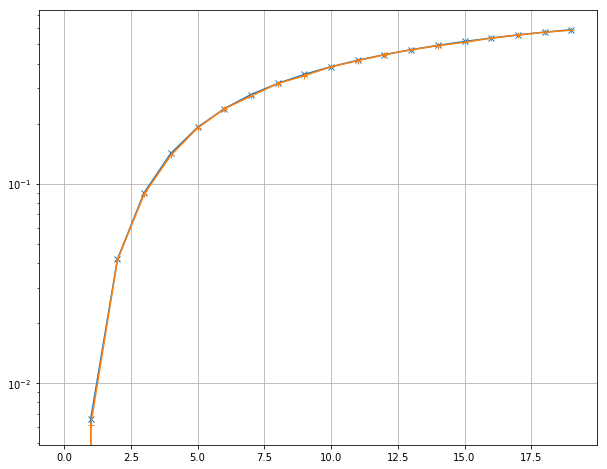

In [363]:
%matplotlib inline
plt.figure(figsize=(10, 8))
plt.plot(simulation_plrs, label='sim', marker='x')
plt.plot(analytical_plrs, label='ana', marker='+')
plt.grid()
plt.yscale('log')

<a id='raf'></a>
# 5. Random Access Function<sup>[toc](#toc)</sup>

<a id='raf_class'></a>
## 5.1 RandomAccessCalculator<sup>[toc](#toc)</sup>

In [143]:
class RandomAccessCalculator(Checker):
    HMR_LOST = 1
    
    def __init__(self, params, verbose=0): 
        """
        :param params - должен содержать следующие ключи: 
            arr_period   - период поступления пакетов (мкс, int)
            delay_bound  - ограничение времени передачи (мкс, int)
            retry_limit  - максимальное число попыток передач на пакет (int)
                            
            res_period   - период зарезервированного интервала (мкс, int)
            det_duration - длительность зарезервированного интервала (мкс, int)
            ran_duration - длительность передаче в случайном доступе (мкс, int)
            mean_access_time - среднее время между передачами в случайном доступе (мкс, int)
                            
            ran_per - вероятность ошибки в случайном доступе (float)
        :type params - dict
        """
        super().__init__()
        self._check_nonnegative(verbose, 'verbose')
        self.verbose = verbose
        
        # Параметры потока
        self.arr_period = params['arr_period']
        self.delay_bound = params['delay_bound']
        #self.input_distr = params['input_distr']
        self.retry_limit = params['retry_limit']
        self.max_batch_size = params['max_batch_size']
        
        self._check_int(self.arr_period, 'arr_period')
        self._check_positive(self.arr_period, 'arr_period')
        self._check_positive(self.delay_bound, 'delay_bound')
        self._check_int(self.retry_limit, 'retry_limit')
        self._check_positive(self.retry_limit, 'retry_limit')
        self._check_int(self.max_batch_size, 'max_batch_size')
        self._check_positive(self.max_batch_size, 'max_batch_size')
        #self._check_distr(self.distr, 'input_distr')
        
        # Параметры доступа к каналу
        self.res_period = params['res_period']
        self.det_duration = params['det_duration']
        self.ran_duration = params['ran_duration']
        self.mean_access_time = params['mean_access_time']
        self._check_int(self.res_period, 'res_period')
        self._check_positive(self.res_period, 'res_period')
        self._check_positive(self.det_duration, 'det_duration')
        self._check_positive(self.ran_duration, 'ran_duration')
        self._check_positive(self.mean_access_time, 'mean_access_time')
        
        # Параметры ошибок
        #self.det_per = params['det_per']
        self.ran_per = params['ran_per']
        #self._check_proba(self.det_per, 'det_per')
        self._check_proba(self.ran_per, 'ran_per')
        
        import math
        self.slot = math.gcd(self.arr_period, self.res_period)
        self.tin = int(self.arr_period / self.slot)
        self.tres = int(self.res_period / self.slot)
        self.d = int(self.delay_bound / self.slot)
        cbap_duration = self.res_period - self.det_duration
        w_distr = self.find_distribution(cbap_duration / self.ran_duration, 
                                         self.mean_access_time / self.ran_duration)

        if self.arr_period < self.res_period:
            raise ValueError("res_period must not exceed arr_period")
        if self.arr_period > self.delay_bound:
            raise ValueError("arr_period must not exceed delay_bound")
        
        M = self.max_batch_size
        R = self.retry_limit
        max_window = len(w_distr) - 1
        self.max_window = max_window
        
        # Сначала найдем L[n, w] - мат. ожидание числа отброшенных пакетов, 
        # когда передача n устаревающих пакетов начинается в начале окна случайного доступа,
        # в котором доступно w попыток передач, и каждый из n пакетов имеет R попыток передач.
        # Пример L[n, 0] = n, L[n, 1] = n - 1 + PER
        self.lost = np.zeros((M + 1, max_window + 1))
        for i in range(1, M + 1):
            for w in range(max_window + 1):
                max_tx_number = min(R, w)
                for tx_number in range(1, max_tx_number + 1):
                    self.lost[i, w] += (1 - self.ran_per) * self.ran_per ** (tx_number - 1) * \
                        self.lost[i - 1, w - tx_number]
                self.lost[i, w] += self.ran_per ** max_tx_number * (1 + self.lost[i - 1, w - max_tx_number])
        
        # Теперь найдем AL[r, n, w] - мат. ожидание числа отброшенных пакетов, 
        # когда HoL-пакет пачки размера n уже передавался r раз в детерминированном доступе.
        self.all_lost = np.zeros((R + 1, M + 1, max_window + 1))
        for r, n, w in product(range(R + 1), range(1, M + 1), range(max_window + 1)):
            max_tx_number = min(R - r, w)
            for tx_number in range(1, max_tx_number + 1):
                self.all_lost[r, n, w] += (1 - self.ran_per) * self.ran_per ** (tx_number - 1) * \
                    self.lost[n - 1, w - tx_number]
            self.all_lost[r, n, w] += self.ran_per ** max_tx_number * (1 + self.lost[n - 1, w - max_tx_number])

        # Теперь найдем C[n, w] - мат. ожидание числа попыток передач в случайном доступе, 
        # когда передача n устаревающих пакетов начинается в начале окна случайного доступа,
        # в котором доступно w попыток передач, и каждый из n пакетов имеет R попыток передач.
        self.etas = np.zeros((M + 1, max_window + 1))
        for i in range(1, M + 1):
            for w in range(max_window + 1):
                max_tx_number = min(R, w)
                for tx_number in range(1, max_tx_number + 1):
                    self.etas[i, w] += (1 - self.ran_per) * self.ran_per ** (tx_number - 1) * \
                        (tx_number + self.etas[i - 1, w - tx_number])
                self.etas[i, w] += self.ran_per ** max_tx_number * (max_tx_number + \
                                                                    self.etas[i - 1, w - max_tx_number])
        # Теперь найдем AC[r, n, w] - мат. ожидание числа попыток передач в случайном доступе, 
        # когда HOL-пакет пачки размера n уже передавался r раз в детерминированном доступе 
        self.all_etas = np.zeros((R + 1, M + 1, max_window + 1))
        for r, n, w in product(range(R + 1), range(1, M + 1), range(max_window + 1)):
            max_tx_number = min(R - r, w)
            for tx_number in range(1, max_tx_number + 1):
                self.all_etas[r, n, w] += (1 - self.ran_per) * self.ran_per ** (tx_number - 1) * \
                                     (tx_number + self.etas[n - 1, w - tx_number])
            self.all_etas[r, n, w] += self.ran_per ** max_tx_number * (max_tx_number + \
                                                                  self.etas[n - 1, w - max_tx_number])
    
    def get_hmr_ranges(self):
        return {'h': (self.tres - self.tin, self.d), 
                'm': (1, self.max_batch_size), 
                'r': (0, self.retry_limit)}
    def get_params(self):
        return {'h_min': self.tres - self.tin, 
                'h_max': self.d,
                'tres': self.tres,
                'tin': self.tin,
                'ran_per': self.ran_per,
                'M': self.max_batch_size,
                'R': self.retry_limit,
                'det_duration': self.det_duration,
                'ran_duration': self.ran_duration,
                'mean_access_time': self.mean_access_time}
    
    def find_distribution(self, window, mean_access_time, tol=1e-10):
        """
        Находит распределение числа попыток передач случайного доступа в окне длительности window при условии,
        что время между попытками распределено экспоненциально со средним mean_access_time. Предполагается, 
        что длительность попытки передачи в случайном доступе равна 1.
        
        :param window - длительность окна передачи
        :type window - float
        
        :param mean_access_time - среднее время доступа к каналу в случайном доступе
        :type mean_access_time - float
        """
        
        mu = 1 / mean_access_time
        distr = []
        sum_of_probas = 0
        
        max_tx_number = int(window)
        for tx_number in range(max_tx_number + 1):
            sum1 = 0
            temp1 = 1
            for i in range(tx_number):
                sum1 += temp1
                temp1 *= mu * (window - tx_number) / (i + 1)
            sum1 = 1 - sum1 * np.exp(-mu * (window - tx_number))
            
            sum2 = 0
            temp2 = 1
            for i in range(tx_number + 1):
                sum2 += temp2
                temp2 *= mu * max(window - tx_number - 1, 0) / (i + 1)
            sum2 = 1 - sum2 * np.exp(-mu * max(window - tx_number - 1, 0))
            distr.append(sum1 - sum2)
            sum_of_probas += distr[-1]
            if np.abs(sum_of_probas - 1) < tol:
                break
        return np.array(distr)  
        
        
    def __call__(self, h, m, r, model_type='ana', **kwargs):
        if (h < self.tres - self.tin) or (h > self.d):
            raise ValueError("h is not in acceptable range.")
        if (m <= 0) or (m > self.max_batch_size):
            raise ValueError("m is not in acceptable range.")
        if (r < 0) or (r > self.retry_limit):
            raise ValueError("r is not in acceptable range.")
            
        if model_type == 'ana':
            return self.run_analytical(h, m, r, **kwargs)
        elif model_type == 'sim':
            return self.run_simulation(h, m, r, **kwargs)
        else:
            return False
        
    def run_analytical(self, h, m, r, **kwargs):
        """
        :param h - время в слотах, которое пакет провел в очереди
        :param m - размер HoL-пачки
        :param r - сколько раз HoL-пакет уже передавался
        """
        if h <= self.d - self.tres: # Пока что пакет еще не устраевает, ничего не теряем.
            return 0, 0
        
        # Нахождение распределения числа попыток передач
        cbap_duration = self.res_period - self.det_duration
        remaining_time = self.delay_bound - h * self.slot - self.det_duration

        if remaining_time < 0: # В случайном доступе теряем все пакеты, так как не осталось времени на передачу
            self.printers[self.HMR_LOST](" No time for transmission in CBAP: " \
                                    "remaining_time = {}, cbap_duration = {}".format(
                                    cbap_duration, remaining_time))
            return m - 1, 0  

        
        remaining_time += self.ran_duration
        remaining_time = min(cbap_duration, remaining_time)

        w_distr = self.find_distribution(remaining_time / self.ran_duration, 
                                         self.mean_access_time / self.ran_duration)

        lost = 0
        cons = 0
        for w in range(len(w_distr)):
            lost += w_distr[w] * self.all_lost[r, m, w]
            cons += w_distr[w] * self.all_etas[r, m, w]
            
            #lost += w_distr[w] * (self.det_per * self.all_lost[r + 1, m, w] + \
            #                          (1 - self.det_per) * self.lost[m - 1, w])
            #cons += w_distr[w] * (self.det_per * self.all_etas[r + 1, m, w] + \
            #                          (1 - self.det_per) * self.etas[m - 1, w])
        return lost, cons
    
    def run_simulation(self, h, m, r, seed=0, **kwargs):
        np.random.seed(seed)
        
        mean_access_time = self.mean_access_time / self.ran_duration
        cbap_duration = (self.res_period - self.det_duration) / self.ran_duration
        remaining_time = (self.delay_bound - h * self.slot - self.det_duration + self.ran_duration) / self.ran_duration
        ran_duration = 1
        window = min(cbap_duration, remaining_time)

        remaining_window = cbap_duration
        n_transmissions = 0
        n_lost = 0
        
        while True:
            if m == 0:
                break
                
            window -= np.random.exponential(mean_access_time)
            if window >= ran_duration:
                n_transmissions += 1
                success = np.random.choice([0, 1], p=[self.ran_per, 1 - self.ran_per])
                if success:
                    m -= 1
                    r = 0
                else:
                    r += 1
                if r == self.retry_limit:
                    n_lost += 1
                    m -= 1
                    r = 0
                window -= ran_duration
            else:
                break
        n_lost += m
        return n_lost, n_transmissions

In [144]:
params['arr_period']  =    40000
params['res_period']  =    15000
params['delay_bound'] =   100000
params['max_batch_size']   = 20
params['mean_access_time'] = 10
params['ran_duration']     = 1012 
params['det_duration']     = 480
params['ran_per']    = 0.3
params['retry_limit'] = 30

raf = RandomAccessCalculator(params, 10)
print(raf.get_hmr_ranges())
print(raf.get_params())
print(raf(18, 10, 0))

n_losts = []
n_transmissions = []

n_runs = 1000
for n_run in range(n_runs):
    n_lost, n_transmission = raf(18, 10, 0, model_type='sim', seed=n_run)
    #print(n_lost, n_transmission)
    n_losts.append(n_lost)
    n_transmissions.append(n_transmission)
print(np.mean(n_losts), np.mean(n_transmissions))

{'h': (-5, 20), 'm': (1, 20), 'r': (0, 30)}
{'h_min': -5, 'h_max': 20, 'tres': 3, 'tin': 8, 'ran_per': 0.3, 'M': 20, 'R': 30, 'det_duration': 480, 'ran_duration': 1012, 'mean_access_time': 10}
(3.0000000010715877, 9.9999999984691605)
3.033 10.0
